In [14]:
# Import required libraries
!pip install librosa
!pip install seaborn
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Add tqdm for progress bar
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import os

# Define paths to dataset
base_path = r"C:\Users\varsh\Downloads\archive\train"
fake_path = os.path.join(base_path, "fake")
real_path = os.path.join(base_path, "real")

print("Fake Path:", fake_path)
print("Real Path:", real_path)


Fake Path: C:\Users\varsh\Downloads\archive\train\fake
Real Path: C:\Users\varsh\Downloads\archive\train\real


In [16]:
import librosa
import numpy as np

def add_noise(data, noise_factor=0.005):
    """
    Adds random noise to the audio signal.
    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data

def time_stretch(data, rate=1.1):
    """
    Stretches the audio signal by a certain rate.
    """
    return librosa.effects.time_stretch(data, rate)

def pitch_shift(data, sr, n_steps=2):
    """
    Shifts the pitch of the audio signal.
    """
    return librosa.effects.pitch_shift(data, sr, n_steps)

def extract_features(file_path, augment=False):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Augmentation if enabled
    if augment:
        aug_choice = np.random.choice(['none', 'noise', 'stretch', 'pitch'])
        if aug_choice == 'noise':
            y = add_noise(y)
        elif aug_choice == 'stretch':
            y = time_stretch(y, rate=np.random.uniform(0.8, 1.2))  # Random stretch factor
        elif aug_choice == 'pitch':
            y = pitch_shift(y, sr, n_steps=np.random.randint(-3, 3))  # Random pitch shift between -3 and 3 semitones
    
    # Extract 40 MFCC (Mel-frequency cepstral coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs_mean = np.mean(mfccs, axis=1)
    
    # Extract additional features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    tonnetz = np.mean(librosa.feature.tonnetz(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
    rmse = np.mean(librosa.feature.rms(y=y))

    # Combine all features into a single vector
    features = np.hstack([mfccs_mean, spectral_centroid, spectral_bandwidth, spectral_contrast, spectral_rolloff, chroma, tonnetz, zero_crossing_rate, rmse])
    
    return features

In [17]:
import os
!pip install tqdm
import numpy as np
from tqdm import tqdm

# Function to load dataset and extract features for a balanced number of audio files
def load_dataset(fake_path, real_path):
    X = []
    y = []
    
    # Get list of files from both fake and real directories
    fake_files = [file for file in os.listdir(fake_path) if file.endswith(".wav")]
    real_files = [file for file in os.listdir(real_path) if file.endswith(".wav")]
    
    # Find the minimum number of files between the two classes for balancing
    min_files = min(len(fake_files), len(real_files))
    
    print(f"Processing {min_files} 'fake' and {min_files} 'real' audio files for balance...")

    # Process fake audio files (only up to min_files to balance the dataset)
    for file_name in tqdm(fake_files[:min_files], desc="Fake files", unit="file"):
        file_path = os.path.join(fake_path, file_name)
        features = extract_features(file_path)
        X.append(features)
        y.append(1)  # Label 1 for fake

    # Process real audio files (only up to min_files to balance the dataset)
    for file_name in tqdm(real_files[:min_files], desc="Real files", unit="file"):
        file_path = os.path.join(real_path, file_name)
        features = extract_features(file_path)
        X.append(features)
        y.append(0)  # Label 0 for real

    # Output the count of files processed for each class
    print(f"Number of 'fake' files processed: {min_files}")
    print(f"Number of 'real' files processed: {min_files}")
    
    return np.array(X), np.array(y), min_files, min_files



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
# Load the dataset with progress bars
X, y, fake_files_count, real_files_count = load_dataset(fake_path, real_path)


Processing 2525 'fake' and 2525 'real' audio files for balance...


C:\Users\varsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=435
  warnings.warn(
C:\Users\varsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=485
  warnings.warn(
C:\Users\varsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=508
  warnings.warn(
C:\Users\varsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=505
  warnings.warn(
C:\Users\varsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=453
  warnings.warn(
C:\Users\varsh\AppData\Local\Programs\Python\Python312\Lib\site-p

Number of 'fake' files processed: 2525
Number of 'real' files processed: 2525


C:\Users\varsh\AppData\Local\Temp\ipykernel_22376\2006424220.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_counts, palette='viridis')


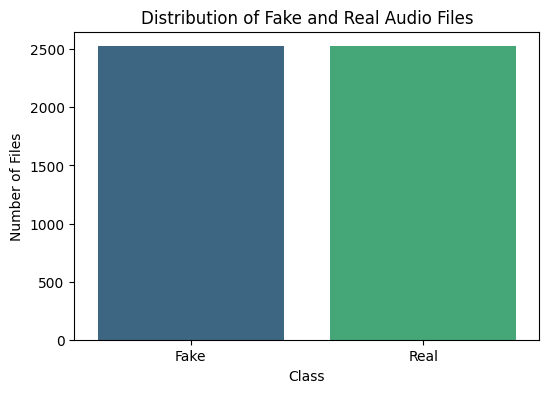

In [26]:
# Visualize the distribution of classes (fake vs real)
class_labels = ['Fake', 'Real']
class_counts = [fake_files_count, real_files_count]

plt.figure(figsize=(6, 4))
sns.barplot(x=class_labels, y=class_counts, palette='viridis')
plt.title('Distribution of Fake and Real Audio Files')
plt.xlabel('Class')
plt.ylabel('Number of Files')
plt.show()


In [27]:
# Split the dataset into training and testing sets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [28]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 98.32%


C:\Users\varsh\AppData\Local\Temp\ipykernel_22376\2201100362.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="magma")


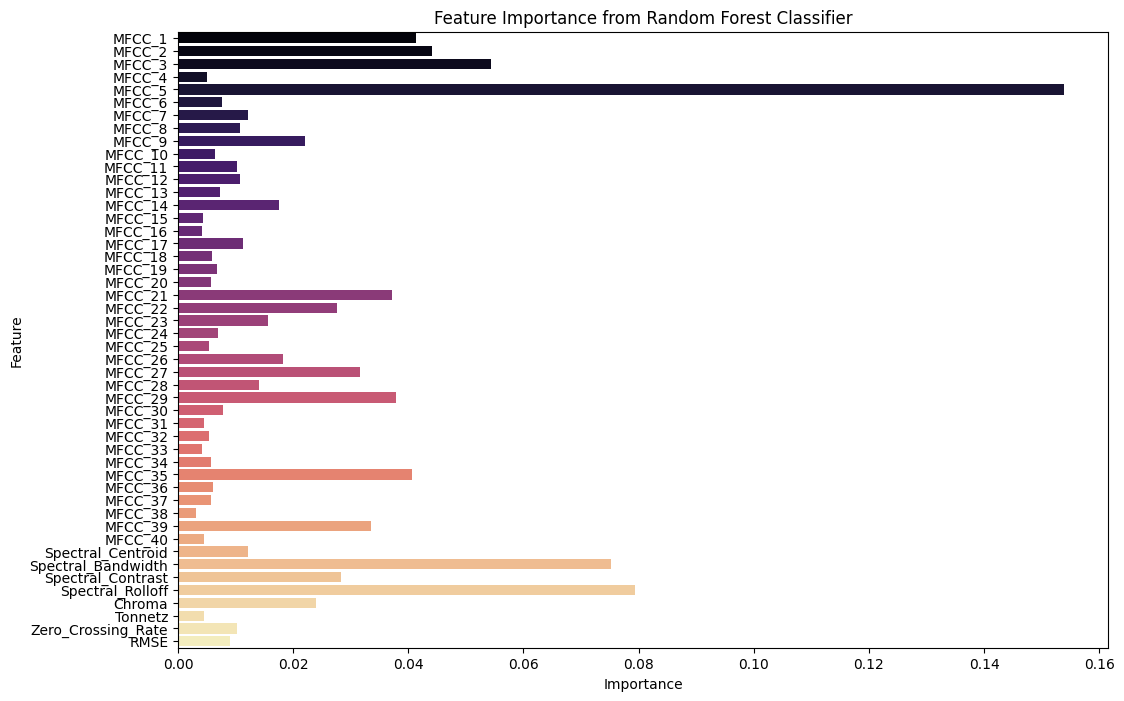

In [29]:
importances = clf.feature_importances_

# Updated feature names
feature_names = [f'MFCC_{i+1}' for i in range(40)] + [
    'Spectral_Centroid', 
    'Spectral_Bandwidth', 
    'Spectral_Contrast', 
    'Spectral_Rolloff', 
    'Chroma', 
    'Tonnetz', 
    'Zero_Crossing_Rate', 
    'RMSE'
]

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=importances, y=feature_names, palette="magma")
plt.title("Feature Importance from Random Forest Classifier")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()



In [30]:
import joblib
from sklearn.metrics import classification_report

# Save the trained Random Forest model to a file
model_filename = "random_forest_model.pkl"
joblib.dump(clf, model_filename)
print(f"Model saved as {model_filename}")

# Load the model from the saved file
loaded_model = joblib.load(model_filename)
print("Model loaded successfully!")

# Generate a classification report on the test set
y_pred = loaded_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=["Real", "Fake"])
print("Classification Report:\n", report)

# Function to predict fake or real for a new .wav file
def predict_fake_or_real(wav_file, model):
    # Extract features from the provided .wav file
    features = extract_features(wav_file)
    features = features.reshape(1, -1)  # Reshape for prediction
    prediction = model.predict(features)

    if prediction[0] == 1:
        return "Fake"
    else:
        return "Real"



Model saved as random_forest_model.pkl
Model loaded successfully!
Classification Report:
               precision    recall  f1-score   support

        Real       0.98      0.98      0.98       480
        Fake       0.98      0.98      0.98       530

    accuracy                           0.98      1010
   macro avg       0.98      0.98      0.98      1010
weighted avg       0.98      0.98      0.98      1010



C:\Users\varsh\AppData\Local\Temp\ipykernel_22376\2882933717.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_counts, palette='viridis')


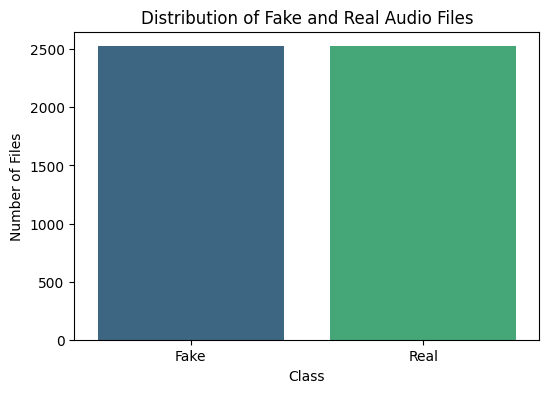

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 48, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 48, 64)            │             256 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 24, 64)            │               0 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 24, 128)           │          66,048 │ max_pooling1d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention (Attention)         │ (None, 24, 128)           │               0 │ bidirectional[0][0],       │
│                               │                           │                 │ bidirectional[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d          │ (None, 128)               │               0 │ attention[0][0]            │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │          16,512 │ global_max_pooling1d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │             129 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 82,945 (324.00 KB)

 Trainable params: 82,945 (324.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.6776 - loss: 0.5851 - val_accuracy: 0.9134 - val_loss: 0.2326
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9373 - loss: 0.1811 - val_accuracy: 0.9592 - val_loss: 0.1042
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9616 - loss: 0.1047 - val_accuracy: 0.9802 - val_loss: 0.0713
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9779 - loss: 0.0680 - val_accuracy: 0.9938 - val_loss: 0.0289
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9726 - loss: 0.0775 - val_accuracy: 0.9913 - val_loss: 0.0348
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9890 - loss: 0.0347 - val_accuracy: 0.9851 - val_loss: 0.0343
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9910 - loss: 0.0337 - val_accuracy: 0.9864 - val_loss: 0.0389
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9809 - loss: 0.0470 - val_accuracy: 0.9913 - v

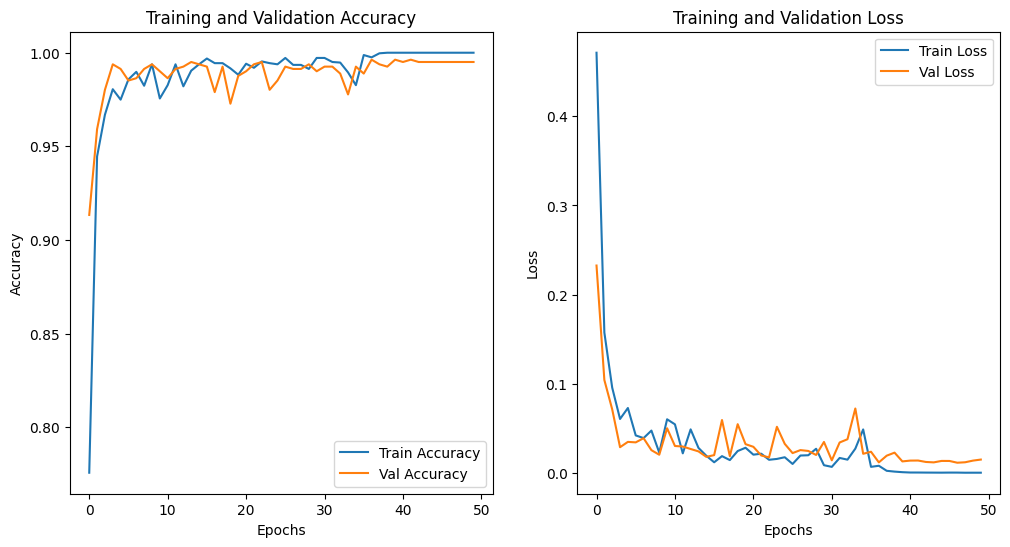

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Flatten, Attention, GlobalMaxPooling1D, Dropout

# Visualize the distribution of classes (fake vs real)
class_labels = ['Fake', 'Real']
class_counts = [fake_files_count, real_files_count]

plt.figure(figsize=(6, 4))
sns.barplot(x=class_labels, y=class_counts, palette='viridis')
plt.title('Distribution of Fake and Real Audio Files')
plt.xlabel('Class')
plt.ylabel('Number of Files')
plt.show()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for CNN input: (samples, time steps, features)
X_train = np.expand_dims(X_train, axis=2)  # Add a channel dimension for CNN
X_test = np.expand_dims(X_test, axis=2)

# Define the CNN-BiLSTM model with Attention
def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN layer
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)

    # BiLSTM layer
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    # Attention mechanism
    attention = Attention()([x, x])
    attention = GlobalMaxPooling1D()(attention)

    # Fully connected layers
    x = Dense(128, activation='relu')(attention)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Build the model
    model = Model(inputs, outputs)
    return model

# Get input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the model
model = build_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the CNN-BiLSTM model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=class_labels))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
